# 生成式对话机器人

## Step1 导入相关包

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

* 这里为什么不用Seq2SeqTrainer, Seq2SeqTrainingArguments呢
  * 因为这里做对话机器人，我们暂时不用评估，只需要计算loss就可以了

## Step2 加载数据集

In [ ]:
ds = Dataset.load_from_disk("./alpaca_data_zh/")
ds

In [ ]:
ds[:3]

## Step3 数据集预处理

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-389m-zh")
tokenizer

* 多轮对话如何训练
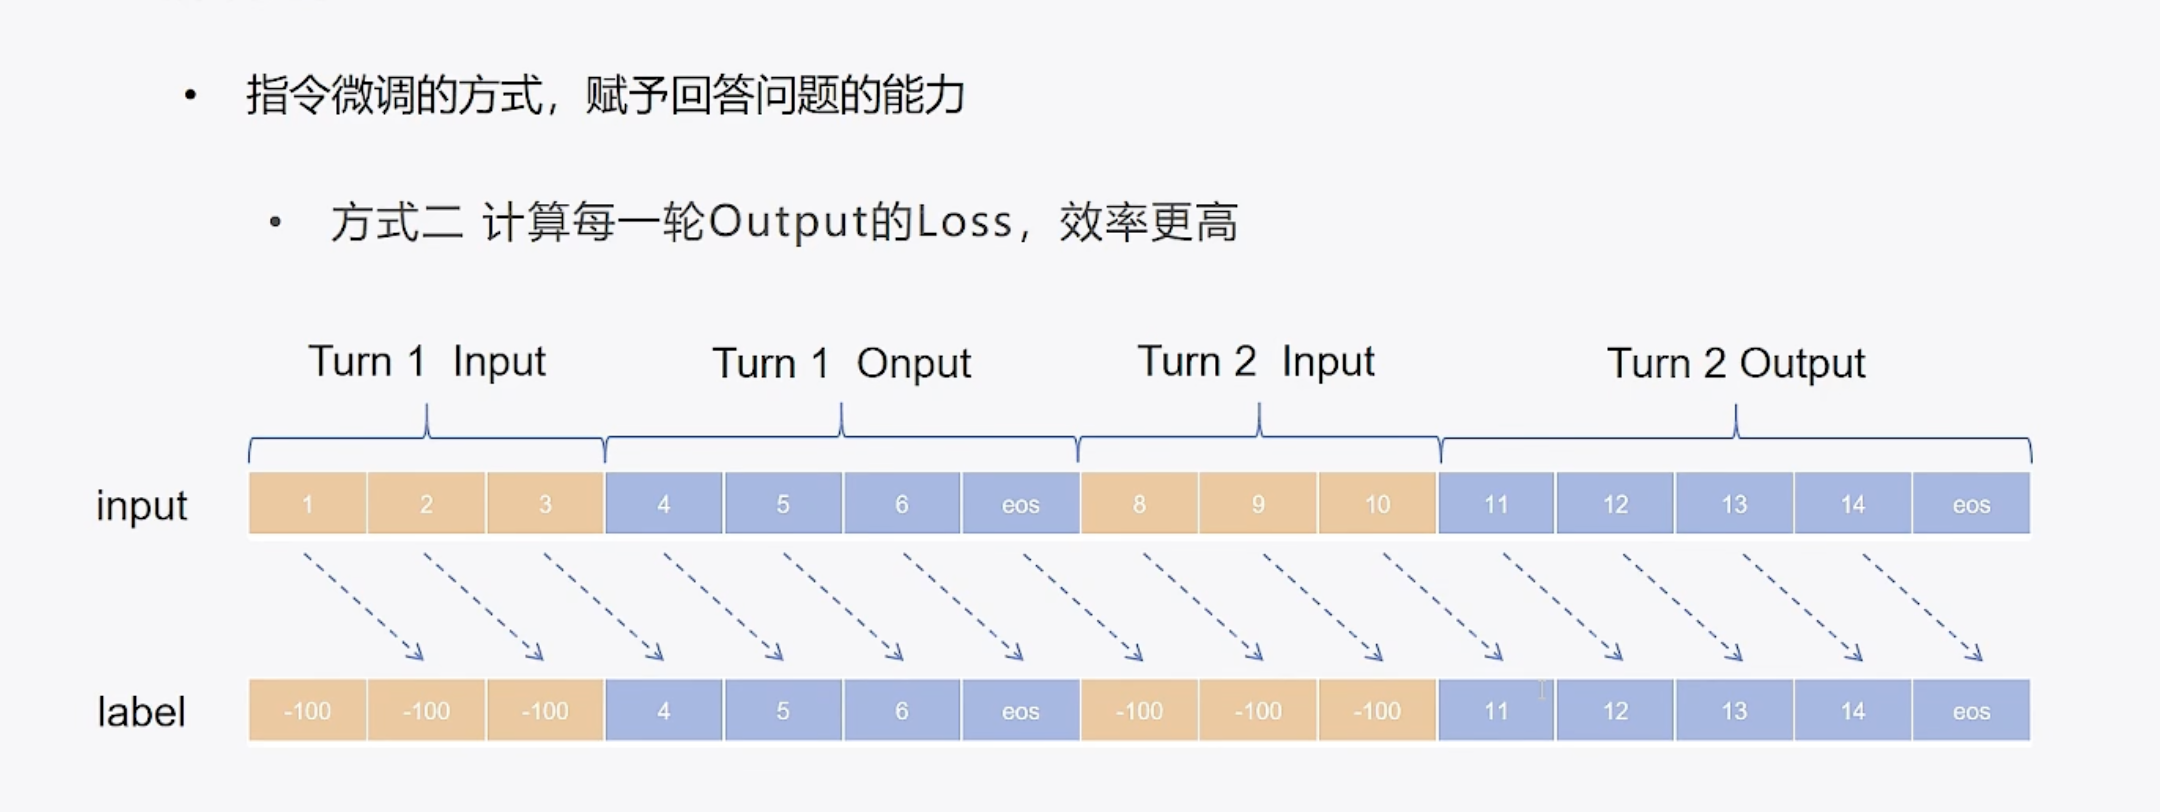 

In [ ]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [ ]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

In [ ]:
tokenizer.decode(tokenized_ds[1]["input_ids"])

In [ ]:
tokenizer.decode(list(filter(lambda x: x != -100, tokenized_ds[1]["labels"])))

## Step4 创建模型

In [ ]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-389m-zh")

## Step5 配置训练参数

In [ ]:
args = TrainingArguments(
    output_dir="./chatbot",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=2
)

## Step6 创建训练器

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True)
)

## Step7 模型训练

In [ ]:
trainer.train()

## Step8 模型推理

In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0)

In [ ]:
ipt = "Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: "
pipe(ipt, max_length=256, do_sample=True, )